<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">MNIST: CNN</h1>
</div>

Problem Type: Multi-classification

## Evaluation Metric

In [1]:
# Black formatter https://black.readthedocs.io/en/stable/

! pip install nb-black > /dev/null

%load_ext lab_black

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Configuration</h1>
</div>

In [2]:
data_dir = "../input/digit-recognizer"

In [3]:
TARGET = "label"

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Import Libraries</h1>
</div>

A best practise is to include all libraries here.  However, I will put a few imports farther down where they are first used so beginners can learn with an "as needed" approach.

In [4]:
import os
import time
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score

# Visualization Libraries
import matplotlib.pylab as plt
import seaborn as sns

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Library</h1>
</div>

Creating a few functions that we will reuse in each project.

In [5]:
def read_data(path):
    data_dir = Path(path)

    train = pd.read_csv(data_dir / "train.csv")
    test = pd.read_csv(data_dir / "test.csv")
    submission_df = pd.read_csv(data_dir / "sample_submission.csv")

    print(f"train data: Rows={train.shape[0]}, Columns={train.shape[1]}")
    print(f"test data : Rows={test.shape[0]}, Columns={test.shape[1]}")
    return train, test, submission_df

In [6]:
def create_submission(model_name, target, preds, is_log_target=False):
    if is_log_target:
        #         preds = np.exp(preds)
        preds = np.expm1(preds)

    sample_submission[target] = preds
    if len(model_name) > 0:
        sample_submission.to_csv(f"submission_{model_name}.csv", index=False)
    else:
        sample_submission.to_csv(f"submission.csv", index=False)

    return sample_submission[:5]

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score


def show_scores(gt, yhat):
    f1 = f1_score(gt, yhat, average="macro")
    mse = mean_squared_error(gt, yhat)
    mae = mean_absolute_error(gt, yhat)
    rmse = np.sqrt(mse)
    #     r2_square = r2_score(gt, yhat)

    print(f"f1: {f1:.4f}")

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Load Train/Test Data</h1>
</div>

- train.csv - Data used to build our machine learning model
- test.csv - Data used to build our machine learning model. Does not contain the target variable
- sample_submission.csv - A file in the proper format to submit test predictions

In [8]:
train, test, sample_submission = read_data(data_dir)

train data: Rows=42000, Columns=785
test data : Rows=28000, Columns=784


In [9]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
FEATURES = [
    col
    for col in train.columns
    if col
    not in [
        "Id",
        TARGET,
        #         TARGET_ENC,
    ]
]

In [11]:
y = train[TARGET]
X = train[FEATURES].copy()

X_test = test[FEATURES].copy()

In [12]:
# Normalize the data
X = X / 255.0
X_test = X_test / 255.0

In [13]:
X = X.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

In [14]:
# X[:3]

In [15]:
from keras.utils.np_utils import to_categorical

y = to_categorical(y)

In [16]:
y[:5]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=42,
)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((37800, 28, 28, 1), (37800, 10), (4200, 28, 28, 1), (4200, 10))

<div style="background-color:rgba(128, 0, 128, 0.6);border-radius:5px;display:fill"><h1 style="text-align: center;padding: 12px 0px 12px 0px;">Create Models</h1>
</div>

In [18]:
### import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


def get_tf_model01(x_shape):
    print(f"x_shape=")
    #     input_shape = (height, width, channels)
    inputs = keras.Input(shape=(28, 28, 1))

    x = keras.layers.Conv2D(
        64,
        kernel_size=3,
        activation="relu",
        padding="same",
        input_shape=(28, 28, 1),
        kernel_initializer="he_normal",
    )(inputs)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Conv2D(
        64,
        kernel_size=3,
        activation="relu",
        padding="same",
        kernel_initializer="he_normal",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    #     x = keras.layers.MaxPooling2d((2, 2))(x)
    #     x = keras.layers.Conv2D(
    #         128, activation="relu", padding="same", kernel_initializer="he_normal"
    #     )(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.BatchNormalization()(x)

    #     x = keras.layers.Dense(128, activation="relu")(x)

    x = keras.layers.Dense(64, activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    x = keras.layers.BatchNormalization()(x)
    #     x = keras.layers.Dropout(0.1)(x)

    outputs = keras.layers.Dense(10, activation="softmax")(x)

    model = keras.Model(inputs, outputs)

    model.compile(
        loss="categorical_crossentropy",
        optimizer="rmsprop",
        metrics=["accuracy"],
    )

    #     model.compile(
    #         optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    #         loss="mean_absolute_error",
    #     )

    return model

In [19]:
X_train.shape[1]

28

In [20]:
X.shape[0]

42000

In [21]:
model = get_tf_model01(x_shape=(28, 28))

model.summary()

x_shape=


2022-07-17 19:30:36.326685: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-17 19:30:36.446341: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-17 19:30:36.447081: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3136)              12544 

2022-07-17 19:30:36.449140: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-17 19:30:36.449521: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-17 19:30:36.450741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-17 19:30:36.451891: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

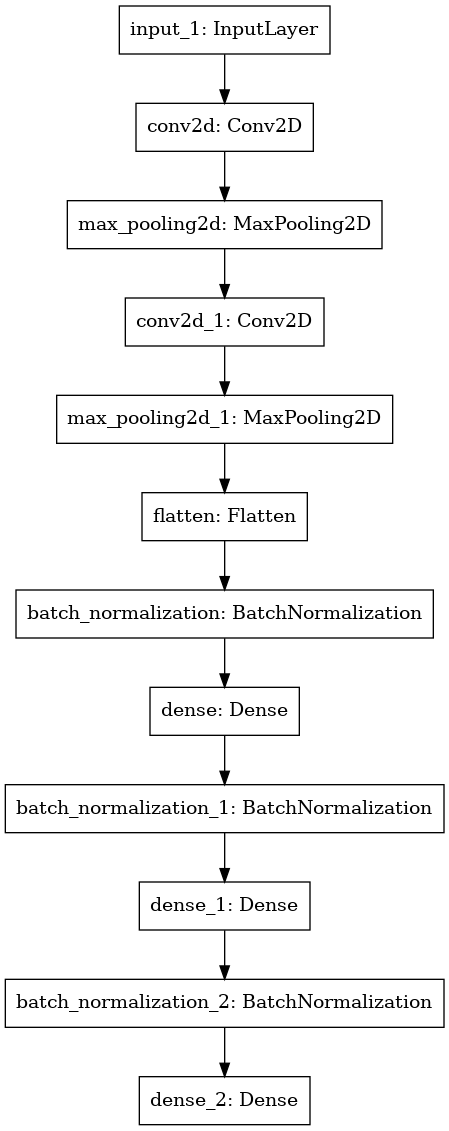

In [22]:
keras.utils.plot_model(model)

In [23]:
%%time

history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=10,
    # Suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2
)

2022-07-17 19:30:39.816913: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-07-17 19:30:41.817499: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


473/473 [==============================] - 11s 7ms/step - loss: 0.1839 - accuracy: 0.9501 - val_loss: 0.1359 - val_accuracy: 0.9562
Epoch 2/10
473/473 [==============================] - 3s 6ms/step - loss: 0.0555 - accuracy: 0.9826 - val_loss: 0.1013 - val_accuracy: 0.9728
Epoch 3/10
473/473 [==============================] - 3s 6ms/step - loss: 0.0374 - accuracy: 0.9876 - val_loss: 0.1348 - val_accuracy: 0.9619
Epoch 4/10
473/473 [==============================] - 3s 7ms/step - loss: 0.0281 - accuracy: 0.9908 - val_loss: 0.0714 - val_accuracy: 0.9796
Epoch 5/10
473/473 [==============================] - 3s 6ms/step - loss: 0.0217 - accuracy: 0.9936 - val_loss: 0.0613 - val_accuracy: 0.9832
Epoch 6/10
473/473 [==============================] - 3s 6ms/step - loss: 0.0169 - accuracy: 0.9941 - val_loss: 0.0544 - val_accuracy: 0.9854
Epoch 7/10
473/473 [==============================] - 3s 6ms/step - loss: 0.0136 - accuracy: 0.9956 - val_loss: 0.0671 - val_accuracy: 0.9820
Epoch 8/10
473/4

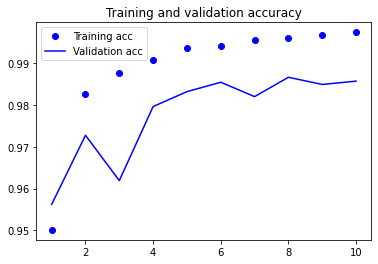

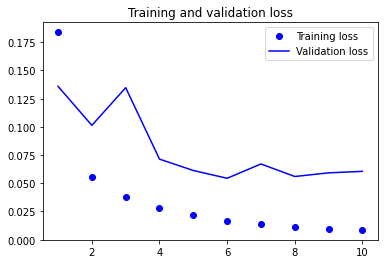

In [24]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

## Predict and Score

In [25]:
test_loss, test_acc = model.evaluate(X_valid, y_valid)
test_acc

132/132 [==============================] - 0s 3ms/step - loss: 0.0519 - accuracy: 0.9881


0.988095223903656

In [26]:
valid_preds = model.predict(X_valid)
valid_preds[:5]

array([[4.50310678e-09, 7.53239637e-10, 1.06846734e-07, 1.48867557e-10,
        9.61560076e-09, 4.69598416e-10, 4.85784124e-09, 5.48133405e-09,
        9.99999881e-01, 1.48438151e-08],
       [1.80863875e-08, 9.99999642e-01, 4.90933849e-10, 9.12615730e-12,
        1.81870959e-07, 7.35310868e-10, 5.14775200e-09, 2.28995262e-07,
        4.99497368e-08, 2.14320273e-09],
       [4.16620383e-09, 1.08063523e-08, 1.11241205e-09, 1.23810452e-07,
        1.16617218e-06, 4.71770782e-08, 1.90388164e-07, 4.72804906e-08,
        3.80878014e-08, 9.99998450e-01],
       [5.32657385e-09, 1.02101767e-08, 2.82422619e-09, 1.10203572e-07,
        1.59790829e-07, 1.28353548e-07, 3.89760899e-08, 1.02698805e-05,
        2.91938733e-07, 9.99989033e-01],
       [3.00590131e-09, 7.24619809e-10, 8.93434127e-09, 7.49930074e-09,
        2.74865517e-08, 2.40876741e-09, 1.77570811e-08, 5.11833287e-09,
        9.99999881e-01, 2.37514950e-08]], dtype=float32)

In [27]:
valid_preds = np.argmax(valid_preds, axis=1)

In [28]:
# show_scores(y_valid, valid_preds)

In [29]:
preds = model.predict(X_test)
preds[:5]

array([[1.69554895e-07, 6.13572624e-08, 9.99999762e-01, 3.38160007e-08,
        6.96885527e-09, 1.83738731e-08, 1.15865095e-08, 1.89490135e-09,
        2.62553765e-08, 2.01962287e-08],
       [9.99998093e-01, 5.16096001e-08, 2.33891441e-07, 3.49247142e-09,
        2.81711787e-09, 1.47509195e-06, 1.66222023e-07, 2.27655228e-08,
        4.01211908e-09, 5.22707708e-08],
       [2.17207100e-10, 1.78160860e-07, 4.55526683e-09, 3.44269750e-08,
        3.44624386e-05, 7.95981165e-08, 3.41332225e-07, 9.67034168e-08,
        1.22090148e-06, 9.99963641e-01],
       [2.94398576e-01, 2.14070747e-06, 2.19643829e-04, 4.34816990e-04,
        5.04004402e-06, 1.39242920e-05, 3.67164575e-05, 2.91805877e-03,
        7.02662102e-04, 7.01268435e-01],
       [1.31951666e-07, 4.77159503e-08, 4.79112032e-06, 9.99976754e-01,
        1.06690919e-07, 1.46977777e-06, 1.11038014e-06, 8.37643839e-08,
        1.03247075e-05, 5.15432794e-06]], dtype=float32)

In [30]:
preds = np.argmax(preds, axis=1)

## Submission

In [31]:
# Different TARGET name used in test.csv
ss = create_submission("", "Label", preds)
ss

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
